# Analyze SNOWPACK Across GrIS

#### Author: Megan Thompson-Munson

#### Date Created: 16 September 2021

## User input

In [1]:
# Provide location of SNOWPACK output files
path = '/projects/metm9666/snowpack/Scripts/Spinup/output/'

# Select the desired date to analyze (YYYY-MM-DD)
desired_date = '2020-12-31'

## Import libraries and set plotting parameters

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
warnings.simplefilter("ignore", UserWarning)

# Set up plotting aesthetics
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 10
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.default'] = 'regular'
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## Read in .pro files

In [66]:
# Get list of of files in output directory
files = os.listdir(path)

# Extract only profiles from directory
VIRs = []
for f in range(len(files)):
    if files[f][-3:] == 'pro':
        idx = files[f].find('_')
        VIR = files[f][3:idx]
        VIRs.append(int(VIR))
VIRs = sorted(VIRs)

In [67]:
# Create an empty list of dataframes to store each one in
dfs = []
        
# Loop through number of files specified in user input
for i in range(len(VIRs)):
    
    # File path and name
#     file = path + 'VIR' + str(pts[i]) + '_GrIS.pro'
#     file = path + profiles[i]
    file = path + 'VIR' + str(VIRs[i]) + '_GrIS.pro'
    
    # Open and read file
    f = open(file,'r')
    
    # Read header and extract location information
    for j in range(44):
        header = f.readline()
        if j == 1:
            VIR = int(header[29:-1])
        if j == 2:
            latitude = float(header[10:-1])
        if j == 3:
            longitude = float(header[11:-1])
        if j == 4:
            elevation = float(header[9:-1])
#         print(header)
    
    timestamps = [] #  Empty list for storing timestamps

    # Read data line by line, beginning after header
    data = f.readlines()
    for line in data:
        linecode = line[0:4] # SNOWPACK gives each data type a 4-digit code

        # Extract timestamps and save in a list
        if linecode == '0500':
            date = datetime.strptime(line[5:24],'%d.%m.%Y %H:%M:%S')
            timestamp = pd.to_datetime(date)
            timestamps.append(timestamp)
            
    # Find SNOWPACK timestamp that's closest to the desired one
    desired_date = pd.to_datetime(desired_date) # Convert desired date to pandas timestamp
    closest = min(timestamps, key=lambda sub: abs(sub - desired_date)) # Function for closest timestamp
    k = np.where(np.array(timestamps)==closest)[0][0] # Index of closest timestamp

    # Read data and extract lines corresponding to closest timestamp
    for line in data:
        linecode = line[0:4] # SNOWPACK gives each data type a 4-digit code
        
        # Extract date
        if linecode == '0500':
            timestamp = datetime.strptime(line[5:24],'%d.%m.%Y %H:%M:%S')
            timestamp = pd.to_datetime(timestamp)

            if timestamp == closest:

                index = k*27 # Each timestamp has 27 elements, so this allows us to get to the start of each new timestamp

                # Extract variables of interest by spliting the lines and creating lists of the data
                height = list(map(float,data[index+1][5:-1].split(',')))[1:] # Height (cm) (converted to m in dataframe)
                h = np.array(height) # Create array of height for conversion to depth 
                depth = (h-h[-1])*-1 # Depth sets surface as 0
                density = list(map(float,data[index+2][5:-1].split(',')))[1:] # Density (kg/m^3)
                temperature = list(map(float,data[index+3][5:-1].split(',')))[1:] # Temperature (dec C)
                water = list(map(float,data[index+6][5:-1].split(',')))[1:] # Water content (%)
                ice = list(map(float,data[index+14][5:-1].split(',')))[1:] # Water content (%)
                air = list(map(float,data[index+15][5:-1].split(',')))[1:] # Water content (%)
                              
                # Create arrays of same length with SNOWPACK metadata 
                vir = np.full((len(height)),VIR)
                t = np.full((len(height)),timestamp)
                latitude = np.full((len(height)),latitude)
                longitude = np.full((len(height)),longitude)
                elevation = np.full((len(height)),elevation)
    
    # Create dataframe for each location
    df = pd.DataFrame(data={'VIR':vir,'Timestamp':t,'Elevation':elevation,'Latitude':latitude,'Longitude':longitude,
                            'Height':np.array(height)/100,'Depth':depth/100,'Density':density,'Temperature':temperature,
                            'Water':np.array(water)/100,'Ice':np.array(ice)/100,'Air':np.array(air)/100})
    
    # Calculate thickness and add to dataframe
    thickness = np.array(df.Height[1:]) - np.array(df.Height[:-1])
    df['Thickness'] = np.insert(thickness, 0, df.Height[0])
    
    dfs.append(df) # Add all dataframes to empty list
    
    f.close() # Close file

In [69]:
dfs[0]

,VIR,Timestamp,Elevation,Latitude,Longitude,Height,Depth,Density,Temperature,Water,Ice,Air,Thickness
0,1,2020-12-28 12:00:00,1912.0,62.0,-46.875,0.9195,188.7360,910.0,-9.49,0.0,0.99,0.01,0.9195
1,1,2020-12-28 12:00:00,1912.0,62.0,-46.875,2.1325,187.5230,910.0,-9.49,0.0,0.99,0.01,1.2130
2,1,2020-12-28 12:00:00,1912.0,62.0,-46.875,3.1668,186.4887,910.0,-9.49,0.0,0.99,0.01,1.0343
3,1,2020-12-28 12:00:00,1912.0,62.0,-46.875,3.4920,186.1635,910.0,-9.49,0.0,0.99,0.01,0.3252
4,1,2020-12-28 12:00:00,1912.0,62.0,-46.875,4.6600,184.9955,910.0,-9.49,0.0,0.99,0.01,1.1680
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,1,2020-12-28 12:00:00,1912.0,62.0,-46.875,189.6254,0.0301,416.8,-12.22,0.0,0.45,0.55,0.0215
195,1,2020-12-28 12:00:00,1912.0,62.0,-46.875,189.6316,0.0239,386.9,-12.45,0.0,0.42,0.58,0.0062
196,1,2020-12-28 12:00:00,1912.0,62.0,-46.875,189.6358,0.0197,373.9,-12.57,0.0,0.41,0.59,0.0042
197,1,2020-12-28 12:00:00,1912.0,62.0,-46.875,189.6453,0.0102,355.0,-12.73,0.0,0.39,0.61,0.0095


## Calculate and plot FAC

In [68]:
# Create empty array to store data
arrayFAC = np.empty((len(dfs),5))

# Loop through each dataframe
for i in range(len(dfs)):
    
    # Select one dataframe at a time
    df = dfs[i]
    
    # Calculate FAC
    fac = np.sum(df.Thickness*df.Air)
    
    # Populate empty array
    arrayFAC[i,0] = df.VIR[0]
    arrayFAC[i,1] = df.Elevation[0]
    arrayFAC[i,2] = df.Latitude[0]
    arrayFAC[i,3] = df.Longitude[0]
    arrayFAC[i,4] = fac
    
# Create dataframe from array
dfFAC = pd.DataFrame(data=arrayFAC,columns=['VIR','Elevation','Latitude','Longitude','FAC'])

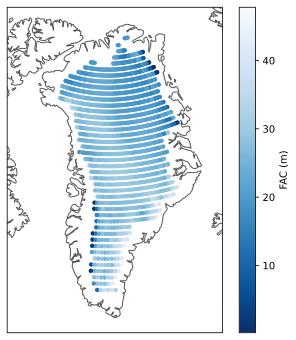

In [7]:
fig = plt.figure(figsize=(6,6))

ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=-45))
ax.set_extent([-60, -28, 58, 85], ccrs.PlateCarree())
ax.coastlines(resolution='50m',color='#555555')
facplot = ax.scatter(dfFAC.Longitude,dfFAC.Latitude,transform=ccrs.PlateCarree(),
             c=dfFAC.FAC,cmap='Blues_r',s=12)

cbar = plt.colorbar(facplot)
cbar.set_label('FAC (m)')

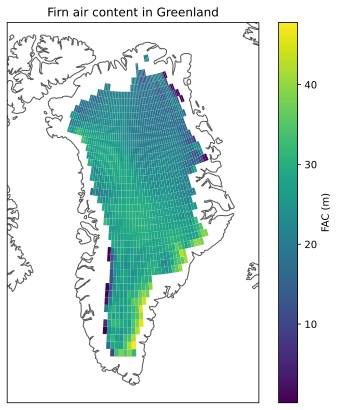

In [70]:
fig = plt.figure(figsize=(7,7))

ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=-45))
ax.set_title('Firn air content in Greenland')
ax.set_extent([-60, -28, 58, 85], ccrs.PlateCarree())
ax.coastlines(resolution='50m',color='#555555')

fac = dfFAC.pivot(index='Latitude',columns='Longitude',values='FAC')

meshFAC = ax.pcolormesh(fac.columns,fac.index,fac,transform=ccrs.PlateCarree(),
                        cmap='viridis',shading='auto',edgecolors=None)

cbar = plt.colorbar(meshFAC)
cbar.set_label('FAC (m)')

In [17]:
dfFAC[dfFAC.FAC>40]

,VIR,Elevation,Latitude,Longitude,FAC
58,58.0,2057.0,65.0,-42.500,45.435902
176,39.0,1898.0,64.0,-42.500,45.864728
244,69.0,1732.0,65.5,-41.875,44.254506
296,13.0,2013.0,62.5,-43.750,47.794436
500,152.0,1570.0,68.0,-33.750,41.251600
697,20.0,2156.0,63.0,-43.750,42.848862
862,128.0,2020.0,67.5,-35.000,40.439586
921,29.0,2086.0,63.5,-43.125,42.239117
928,12.0,2379.0,62.5,-44.375,41.965474
957,176.0,1759.0,68.5,-33.750,40.170760


In [22]:
dfs[0]

,VIR,Timestamp,Elevation,Latitude,Longitude,Height,Depth,Density,Temperature,Water,Ice,Air,Thickness
0,465,2020-12-28 12:00:00,3007.0,73.0,-33.125,0.7973,156.9754,910.0,-28.89,0.0,0.99,0.01,0.7973
1,465,2020-12-28 12:00:00,3007.0,73.0,-33.125,1.9066,155.8661,910.0,-28.89,0.0,0.99,0.01,1.1093
2,465,2020-12-28 12:00:00,3007.0,73.0,-33.125,3.2089,154.5638,910.0,-28.89,0.0,0.99,0.01,1.3023
3,465,2020-12-28 12:00:00,3007.0,73.0,-33.125,4.1907,153.5820,910.0,-28.89,0.0,0.99,0.01,0.9818
4,465,2020-12-28 12:00:00,3007.0,73.0,-33.125,5.4634,152.3093,910.0,-28.89,0.0,0.99,0.01,1.2727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,465,2020-12-28 12:00:00,3007.0,73.0,-33.125,157.7466,0.0261,389.8,-36.18,0.0,0.43,0.57,0.0158
200,465,2020-12-28 12:00:00,3007.0,73.0,-33.125,157.7527,0.0200,355.8,-36.25,0.0,0.39,0.61,0.0061
201,465,2020-12-28 12:00:00,3007.0,73.0,-33.125,157.7577,0.0150,349.1,-36.27,0.0,0.38,0.62,0.0050
202,465,2020-12-28 12:00:00,3007.0,73.0,-33.125,157.7618,0.0109,320.9,-36.29,0.0,0.35,0.65,0.0041
